# Final Project Submission

- Student name: Edward Cheng
- Student pace: Self-paced
- Scheduled project review date/time: 
- Instructor name: Jeff Herman
- Blog post URL: https://medium.com/@edwardcheng22/nlp-twitter-sentiment-classification-tutorial-fb99dd2bf253

# Contents

 <b>1) Preprocessing:</b>
 
     - Clean data set, including checking for NA values
     - Stopword Removal
         - Removal of Punctuations and/or numbers
         - Removal of Capitlizations
         - Regex
     - Stemming/Lemmitazation
     - Noise Removal
     - Tokenization
     
 <b>2) Exploratory Data Analysis:</b>
 
     - Words
     - Sentences
     - Hashtags

 <b>3) Feature Engineering:</b>

     - Bigrams/N-grams
     - Mutual Information Score
     - Text Vectorization

 <b>4) Modelling:</b>
 
     - Naive Bayes Multinomial Classifier
     - Logistic Regression
     - Random Forest
     - Support Vector Classifier
     - Deep Neural Networks(Base model)
     - Deep Neural Networks(Regularized, with dropout)

<b>Import Libraries</b>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#For NLP preprocessing
from nltk.corpus import stopwords
from nltk import word_tokenize
import string #for removing punctuation from text
import nltk
from nltk.collocations import *
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer # for word lemmatizing
import re
from wordcloud import WordCloud

# MODELING:
from sklearn.preprocessing import StandardScaler #For normalizing data
#To divide data when testing a trained model
from sklearn.model_selection import train_test_split 
# Multinomial NB Model 
from sklearn.naive_bayes import MultinomialNB
#To build regular logistic regression models
from sklearn.linear_model import LogisticRegression
# ENSEMBLE METHODS:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing


# ASSESSING MODELS:
#To assess accuracy of logistic regression or decision trees
from sklearn.model_selection import RandomizedSearchCV

#To get accuracy, precision, recall, and F1 score (weighted accuracy) of a given confusion matrix
from sklearn.metrics import accuracy_score
#To view the accuracy metrics for a given confusion matrix
from sklearn.metrics import classification_report

#For neural network preprocessing
from keras.utils.np_utils import to_categorical
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense
from keras.layers import Dropout, Activation
from keras.models import Model
from keras import models, regularizers, optimizers, layers
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [4]:
#Needed for first time use on each machine:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Import Data set

In [5]:
df = pd.read_csv('tweets_apple_google.csv')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


# 1) Preprocessing

Before we start with the preprocessing, let's first rename the columns.

In [6]:
# Rename columns
df.rename(columns = {'emotion_in_tweet_is_directed_at': 'device', 'is_there_an_emotion_directed_at_a_brand_or_product': 'product_emotion'}, inplace = True)

In [7]:
df.head()

,tweet_text,device,product_emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
df.shape

(9093, 3)

Now let's inspect the unique values of the device and product_emotion columns

In [9]:
# Preview the unique values in the two selected columns
unique_list = ['device', 'product_emotion']
for col in unique_list:
    print(df[col].value_counts())
    print('-' * 100)

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: device, dtype: int64
----------------------------------------------------------------------------------------------------
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: product_emotion, dtype: int64
----------------------------------------------------------------------------------------------------


We notice that there are a lot of similar values in the device column, it would be wise to group them all together into only a couple categories. Android app and Android seem to be telling the same thing, and the number of values for 'Other Apple product or service' doesn't seem to be too important, so I will merge those values into the 'Apple' value. Before we do that however, we need to check in with the NA values.

<b>1.1) Clean data set, including checking for NA values</b>

In [10]:
# Check for the number of NA values
df.isnull().sum()

tweet_text            1
device             5802
product_emotion       0
dtype: int64

In [11]:
# Drop the null values
df.dropna(subset=['tweet_text'], inplace = True)

In [12]:
df.isnull().sum()

tweet_text            0
device             5801
product_emotion       0
dtype: int64

In [13]:
print(df['device'].isnull().value_counts(normalize = True))

True     0.638033
False    0.361967
Name: device, dtype: float64


In [14]:
df.loc[:, ['device']] = df.loc[:, ['device']].fillna('Not Known')

In [15]:
df.isnull().sum()

tweet_text         0
device             0
product_emotion    0
dtype: int64

In [16]:
df['device'].value_counts(normalize = True)

Not Known                          0.638033
iPad                               0.104048
Apple                              0.072701
iPad or iPhone App                 0.051694
Google                             0.047294
iPhone                             0.032666
Other Google product or service    0.032226
Android App                        0.008909
Android                            0.008579
Other Apple product or service     0.003850
Name: device, dtype: float64

In [17]:
df['product_emotion'].value_counts(normalize = True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327541
Negative emotion                      0.062692
I can't tell                          0.017158
Name: product_emotion, dtype: float64

In [18]:
# Delete the values that are called "I can't tell"
cant_tell = df.loc[df['product_emotion'].str.contains("I can't tell")].index

In [19]:
df.drop(cant_tell, axis = 0, inplace = True)

In [20]:
df['product_emotion'].value_counts(normalize = True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: product_emotion, dtype: float64

Let's also rename the values 'no emotion toward brand or product' to 'neutral' to condense things

In [21]:
df['product_emotion'].replace({'No emotion toward brand or product': 'Neutral'}, inplace = True)

In [22]:
df['product_emotion'].value_counts(normalize = True)

Neutral             0.602954
Positive emotion    0.333259
Negative emotion    0.063787
Name: product_emotion, dtype: float64

In [23]:
df

,tweet_text,device,product_emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",Not Known,Neutral
9090,"Google's Zeiger, a physician never reported po...",Not Known,Neutral
9091,Some Verizon iPhone customers complained their...,Not Known,Neutral


Before we move on to the next section, we need to convert the product emotion category into integer values for modelling purposes

In [24]:
In [11]: df['product_emotion'].replace({'Positive emotion': '0', 'Negative emotion': '1', 'Neutral': '2'}, inplace = True)

In [25]:
# Convert to integers
df["product_emotion"] = df["product_emotion"].astype(int)

In [26]:
df.head()

,tweet_text,device,product_emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,0
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,0
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0


<b>1.2) Stopword removal</b>

In [27]:
# Get a preview of the first 50 tweets
print(df.tweet_text[:50])

0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1     @jessedee Know about @fludapp ? Awesome iPad/i...
2     @swonderlin Can not wait for #iPad 2 also. The...
3     @sxsw I hope this year's festival isn't as cra...
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...
5     @teachntech00 New iPad Apps For #SpeechTherapy...
7     #SXSW is just starting, #CTIA is around the co...
8     Beautifully smart and simple idea RT @madebyma...
9     Counting down the days to #sxsw plus strong Ca...
10    Excited to meet the @samsungmobileus at #sxsw ...
11    Find &amp; Start Impromptu Parties at #SXSW Wi...
12    Foursquare ups the game, just in time for #SXS...
13    Gotta love this #SXSW Google Calendar featurin...
14    Great #sxsw ipad app from @madebymany: http://...
15    haha, awesomely rad iPad app by @madebymany ht...
16    Holler Gram for iPad on the iTunes App Store -...
17    I just noticed DST is coming this weekend. How...
18    Just added my #SXSW flights to @planely. M

In [28]:
# Convert to lowercase
df.loc[:, 'tweet_text'] = df.tweet_text.apply(lambda x: str.lower(x))

In [29]:
print(df.tweet_text[:50])

0     .@wesley83 i have a 3g iphone. after 3 hrs twe...
1     @jessedee know about @fludapp ? awesome ipad/i...
2     @swonderlin can not wait for #ipad 2 also. the...
3     @sxsw i hope this year's festival isn't as cra...
4     @sxtxstate great stuff on fri #sxsw: marissa m...
5     @teachntech00 new ipad apps for #speechtherapy...
7     #sxsw is just starting, #ctia is around the co...
8     beautifully smart and simple idea rt @madebyma...
9     counting down the days to #sxsw plus strong ca...
10    excited to meet the @samsungmobileus at #sxsw ...
11    find &amp; start impromptu parties at #sxsw wi...
12    foursquare ups the game, just in time for #sxs...
13    gotta love this #sxsw google calendar featurin...
14    great #sxsw ipad app from @madebymany: http://...
15    haha, awesomely rad ipad app by @madebymany ht...
16    holler gram for ipad on the itunes app store -...
17    i just noticed dst is coming this weekend. how...
18    just added my #sxsw flights to @planely. m

In [30]:
# Function that removes punctuations
def remove_punc(s):
    punc_list = [".",";",":","!","?","/","\\",",","@","$","&",")","(","'","\""]
    new_s = ''
    for i in s:
        if i not in punc_list:
            new_s += i
        else:
            new_s += ' '
    return new_s.lower()    
  # punc_list = '''!()-[]{};:'"\,<>./?$@%^&*_~'''
    # s = ' '.join(word for word in s.split() if word not in punc_list)
    # return s

In [31]:
# Remove punctuation and stopwords
df.loc[:,"tweet_text"] = df.tweet_text.apply(lambda x: remove_punc(x))

In [32]:
df.tweet_text[:50]

0       wesley83 i have a 3g iphone  after 3 hrs twe...
1      jessedee know about  fludapp   awesome ipad i...
2      swonderlin can not wait for #ipad 2 also  the...
3      sxsw i hope this year s festival isn t as cra...
4      sxtxstate great stuff on fri #sxsw  marissa m...
5      teachntech00 new ipad apps for #speechtherapy...
7     #sxsw is just starting  #ctia is around the co...
8     beautifully smart and simple idea rt  madebyma...
9     counting down the days to #sxsw plus strong ca...
10    excited to meet the  samsungmobileus at #sxsw ...
11    find  amp  start impromptu parties at #sxsw wi...
12    foursquare ups the game  just in time for #sxs...
13    gotta love this #sxsw google calendar featurin...
14    great #sxsw ipad app from  madebymany  http   ...
15    haha  awesomely rad ipad app by  madebymany ht...
16    holler gram for ipad on the itunes app store -...
17    i just noticed dst is coming this weekend  how...
18    just added my #sxsw flights to  planely  m

In [33]:
# Remove stopwords
def remove_stopWords(s):
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    stopwords_list += ["''", '""', '...', '``']
    
    s = ' '.join(word for word in s.split() if word not in stopwords_list)
    return s

In [34]:
df.loc[:,"tweet_text"] = df.tweet_text.apply(lambda x: remove_stopWords(x))

In [35]:
df.tweet_text[:50]

0     wesley83 3g iphone 3 hrs tweeting #rise_austin...
1     jessedee know fludapp awesome ipad iphone app ...
2               swonderlin wait #ipad 2 also sale #sxsw
3     sxsw hope year festival crashy year iphone app...
4     sxtxstate great stuff fri #sxsw marissa mayer ...
5     teachntech00 new ipad apps #speechtherapy comm...
7     #sxsw starting #ctia around corner #googleio h...
8     beautifully smart simple idea rt madebymany th...
9     counting days #sxsw plus strong canadian dolla...
10    excited meet samsungmobileus #sxsw show sprint...
11    find amp start impromptu parties #sxsw hurrica...
12    foursquare ups game time #sxsw http j mp grn7p...
13    gotta love #sxsw google calendar featuring top...
14    great #sxsw ipad app madebymany http tinyurl c...
15    haha awesomely rad ipad app madebymany http bi...
16    holler gram ipad itunes app store http co kfn3...
17    noticed dst coming weekend many iphone users h...
18    added #sxsw flights planely matching peopl

In [36]:
# Create a copy of the data set that keeps hashtags
hashtag_df = df.copy()

In [37]:
hashtag_df.head()

,tweet_text,device,product_emotion
0,wesley83 3g iphone 3 hrs tweeting #rise_austin...,iPhone,1
1,jessedee know fludapp awesome ipad iphone app ...,iPad or iPhone App,0
2,swonderlin wait #ipad 2 also sale #sxsw,iPad,0
3,sxsw hope year festival crashy year iphone app...,iPad or iPhone App,1
4,sxtxstate great stuff fri #sxsw marissa mayer ...,Google,0


<b>1.3) Stemming/Lemmitization</b>

Stemming and Lemmitazation both produce relatively similar results, but the difference between stemming and lemmatization is that lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors. Here is an example of the difference: 
    - Stemming: Caring -> Car 
    - Lemmitazation: Caring -> Care

In [38]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [39]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
# Perform Lemmitization on all the words in the data set
def lemmatization(s):
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    #Tokenize: Split the sentence into words
    word_list = nltk.word_tokenize(s)
  
    # Lemmatize list of words and join
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [41]:
df.loc[:,"tweet_text"] = df.tweet_text.apply(lambda x: lemmatization(x))
df.tweet_text[:50]

0     wesley83 3g iphone 3 hr tweeting # rise_austin...
1     jessedee know fludapp awesome ipad iphone app ...
2             swonderlin wait # ipad 2 also sale # sxsw
3     sxsw hope year festival crashy year iphone app...
4     sxtxstate great stuff fri # sxsw marissa mayer...
5     teachntech00 new ipad apps # speechtherapy com...
7     # sxsw starting # ctia around corner # googlei...
8     beautifully smart simple idea rt madebymany th...
9     counting day # sxsw plus strong canadian dolla...
10    excited meet samsungmobileus # sxsw show sprin...
11    find amp start impromptu party # sxsw hurrican...
12    foursquare ups game time # sxsw http j mp grn7...
13    got ta love # sxsw google calendar featuring t...
14    great # sxsw ipad app madebymany http tinyurl ...
15    haha awesomely rad ipad app madebymany http bi...
16    holler gram ipad itunes app store http co kfn3...
17    noticed dst coming weekend many iphone user ho...
18    added # sxsw flight planely matching peopl

<b>1.4) Noise Removal</b>

In [42]:
# Remove more unnecessary symbols/characters and words
def remove_stopWords_modified(s):
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    stopwords_list += ["''", '""', '...', '``']
    stopwords_list += ['mention', 'link', 'rt', 'i', 'u', 'user', '‰û÷', '‰ûª', '‰ûï', '‰', 'ûª', 
                       'û_', 'ûªll', 'ûªre', 'ûªs', 'ûªt', 'ûï', 'ûò', 'ûó', '‰û÷hobo‰ûª', '‰û÷hobo']
    s = ' '.join(word for word in s.split() if word not in stopwords_list)
    return s

In [43]:
df.loc[:,"tweet_text"] = df.tweet_text.apply(lambda x: remove_stopWords_modified(x))

In [44]:
df.tweet_text[:50]

0     wesley83 3g iphone 3 hr tweeting rise_austin d...
1     jessedee know fludapp awesome ipad iphone app ...
2                 swonderlin wait ipad 2 also sale sxsw
3     sxsw hope year festival crashy year iphone app...
4     sxtxstate great stuff fri sxsw marissa mayer g...
5     teachntech00 new ipad apps speechtherapy commu...
7     sxsw starting ctia around corner googleio hop ...
8     beautifully smart simple idea madebymany thene...
9     counting day sxsw plus strong canadian dollar ...
10    excited meet samsungmobileus sxsw show sprint ...
11    find amp start impromptu party sxsw hurricanep...
12    foursquare ups game time sxsw http j mp grn7pk...
13    got ta love sxsw google calendar featuring top...
14    great sxsw ipad app madebymany http tinyurl co...
15    haha awesomely rad ipad app madebymany http bi...
16    holler gram ipad itunes app store http co kfn3...
17    noticed dst coming weekend many iphone hour la...
18    added sxsw flight planely matching people 

In [45]:
# Function that removes numbers
def no_numbers(s):
  number_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  s = ' '.join(word for word in s.split() if word not in number_list)
  return s 

In [46]:
df.loc[:,"tweet_text"] = df.tweet_text.apply(lambda x: no_numbers(x))

In [47]:
df.tweet_text[:50]

0     wesley83 3g iphone hr tweeting rise_austin dea...
1     jessedee know fludapp awesome ipad iphone app ...
2                   swonderlin wait ipad also sale sxsw
3     sxsw hope year festival crashy year iphone app...
4     sxtxstate great stuff fri sxsw marissa mayer g...
5     teachntech00 new ipad apps speechtherapy commu...
7     sxsw starting ctia around corner googleio hop ...
8     beautifully smart simple idea madebymany thene...
9     counting day sxsw plus strong canadian dollar ...
10    excited meet samsungmobileus sxsw show sprint ...
11    find amp start impromptu party sxsw hurricanep...
12    foursquare ups game time sxsw http j mp grn7pk...
13    got ta love sxsw google calendar featuring top...
14    great sxsw ipad app madebymany http tinyurl co...
15    haha awesomely rad ipad app madebymany http bi...
16    holler gram ipad itunes app store http co kfn3...
17    noticed dst coming weekend many iphone hour la...
18    added sxsw flight planely matching people 

We will keep this data set for later to test out the model's accuracy with and witout numbers. Numbers may or may not be indicative of a better accuracy score because we are dealing with apple and google product devices, so there may be several words like 'ipad 2' or 'iphone 3G' present that could be useful information. However, the model accuracy could also be better without the rest of the uninformative numbers lying around. We will explore later, but for now I will move on to the tokenization of the data set for EDA purposes.

<b>1.5) Tokenization</b>

Let's take a look at the top 200 words to observe for any other strange characters that could be eliminated for better modelling results

In [48]:
# Function that converts the tweets into tokenized words
def identify_tokens(row):
    tokens = nltk.word_tokenize(row)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

In [49]:
df['tokens'] = df.tweet_text.apply(lambda x: identify_tokens(x))

In [50]:
df.head()

,tweet_text,device,product_emotion,tokens
0,wesley83 3g iphone hr tweeting rise_austin dea...,iPhone,1,"[iphone, hr, tweeting, dead, need, upgrade, pl..."
1,jessedee know fludapp awesome ipad iphone app ...,iPad or iPhone App,0,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,swonderlin wait ipad also sale sxsw,iPad,0,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,sxsw hope year festival crashy year iphone app...,iPad or iPhone App,1,"[sxsw, hope, year, festival, crashy, year, iph..."
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,0,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


In [51]:
# Append the tokenized words
tokens_concat = []
for word in df['tokens']:
    tokens_concat += word

In [52]:
print(len(tokens_concat))

91171


In [53]:
tokens_concat

['iphone',
 'hr',
 'tweeting',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw',
 'jessedee',
 'know',
 'fludapp',
 'awesome',
 'ipad',
 'iphone',
 'app',
 'likely',
 'appreciate',
 'design',
 'also',
 'giving',
 'free',
 'sxsw',
 'swonderlin',
 'wait',
 'ipad',
 'also',
 'sale',
 'sxsw',
 'sxsw',
 'hope',
 'year',
 'festival',
 'crashy',
 'year',
 'iphone',
 'app',
 'sxsw',
 'sxtxstate',
 'great',
 'stuff',
 'fri',
 'sxsw',
 'marissa',
 'mayer',
 'google',
 'tim',
 'reilly',
 'tech',
 'book',
 'conference',
 'amp',
 'matt',
 'mullenweg',
 'wordpress',
 'new',
 'ipad',
 'apps',
 'speechtherapy',
 'communication',
 'showcased',
 'sxsw',
 'conference',
 'http',
 'ht',
 'ly',
 'iear',
 'edchat',
 'asd',
 'sxsw',
 'starting',
 'ctia',
 'around',
 'corner',
 'googleio',
 'hop',
 'skip',
 'jump',
 'good',
 'time',
 'android',
 'fan',
 'beautifully',
 'smart',
 'simple',
 'idea',
 'madebymany',
 'thenextweb',
 'wrote',
 'hollergram',
 'ipad',
 'app',
 'sxsw',
 'http',
 'bit',
 'ly

In [54]:
# Observe the most frequently seen words
most_freq_tweet_words = FreqDist(tokens_concat)
most_freq_tweet_words.most_common(200)

[('sxsw', 9372),
 ('google', 2594),
 ('ipad', 2457),
 ('apple', 2281),
 ('quot', 1657),
 ('iphone', 1541),
 ('store', 1498),
 ('new', 1078),
 ('austin', 949),
 ('amp', 834),
 ('app', 815),
 ('launch', 685),
 ('circle', 666),
 ('social', 637),
 ('android', 588),
 ('today', 576),
 ('network', 467),
 ('get', 451),
 ('line', 432),
 ('via', 428),
 ('party', 397),
 ('free', 387),
 ('called', 354),
 ('mobile', 345),
 ('sxswi', 337),
 ('one', 311),
 ('major', 303),
 ('time', 299),
 ('like', 291),
 ('day', 276),
 ('map', 265),
 ('temporary', 262),
 ('w', 257),
 ('opening', 256),
 ('open', 249),
 ('win', 241),
 ('need', 236),
 ('possibly', 236),
 ('come', 228),
 ('people', 226),
 ('see', 226),
 ('downtown', 225),
 ('apps', 222),
 ('great', 221),
 ('go', 221),
 ('check', 218),
 ('mayer', 216),
 ('going', 213),
 ('popup', 209),
 ('know', 196),
 ('marissa', 189),
 ('got', 182),
 ('want', 176),
 ('make', 176),
 ('good', 172),
 ('first', 166),
 ('think', 166),
 ('year', 164),
 ('say', 161),
 ('pop', 

Knowing the frequency with which each word is used is somewhat informative, but without the context of how many words are used in total, it doesn't tell us much. One way we can adjust for this is to use Normalized Word Frequency, which we can compute by dividing each word frequency by the total number of words. Let's observe for the top 100 frequent words this time.

In [55]:
# Normalized frequency of the top 100 words
total_word_count = sum(most_freq_tweet_words.values())
top_100_tweeted_words = most_freq_tweet_words.most_common(100)
print('Word\t\t\tNormalized Frequency')
for word in top_100_tweeted_words:
    normalized_freq = word[1] / total_word_count
    print('{} \t\t\t {:.4}'.format(word[0], normalized_freq))

Word			Normalized Frequency
sxsw 			 0.1028
google 			 0.02845
ipad 			 0.02695
apple 			 0.02502
quot 			 0.01817
iphone 			 0.0169
store 			 0.01643
new 			 0.01182
austin 			 0.01041
amp 			 0.009148
app 			 0.008939
launch 			 0.007513
circle 			 0.007305
social 			 0.006987
android 			 0.006449
today 			 0.006318
network 			 0.005122
get 			 0.004947
line 			 0.004738
via 			 0.004694
party 			 0.004354
free 			 0.004245
called 			 0.003883
mobile 			 0.003784
sxswi 			 0.003696
one 			 0.003411
major 			 0.003323
time 			 0.00328
like 			 0.003192
day 			 0.003027
map 			 0.002907
temporary 			 0.002874
w 			 0.002819
opening 			 0.002808
open 			 0.002731
win 			 0.002643
need 			 0.002589
possibly 			 0.002589
come 			 0.002501
people 			 0.002479
see 			 0.002479
downtown 			 0.002468
apps 			 0.002435
great 			 0.002424
go 			 0.002424
check 			 0.002391
mayer 			 0.002369
going 			 0.002336
popup 			 0.002292
know 			 0.00215
marissa 			 0.002073
got 			 0.001996
want 			 0.

The following observations have been made:
  - sxsw is the most frequently seen word, and at first glance the word doesn't seem comprehensible. After further research, I found that the acronym stood for 'South by Southwest', which is an annual conglomeration of parallel film, interactive media, and music festivals and conferences organized jointly that take place in mid-March in Austin, Texas, United States. As you can see, the word 'Austin' is also one of the most frequently seen words.
  - 'mention' can be eliminated, as it is not necessary and is only used before a username. We can use regex to get rid of the word mention and the username that follows because they are not important
  - link is also not necessary 
  - RT stands for retweet presumably, so we can exclude these words too
  - 'i' is the lowercased version of I and did not seem to be picked up by the stopwords list, so we can eliminate this too
  - 'u' is the same scenario as the one above
  - 'user' is probably referencing to the tweeter's account, so that isn't too important to keep

In [56]:
# Remove more unwanted words
selected_words = ['mention', 'link', 'rt', 'i', 'u', 'user']
tokens_concat_new = []
for word in tokens_concat:  # iterating on a copy since removing will mess things up
    if word not in selected_words:
        tokens_concat_new.append(word)

In [57]:
most_freq_tweet_words_modified = FreqDist(tokens_concat_new)
most_freq_tweet_words_modified.most_common(100)

[('sxsw', 9372),
 ('google', 2594),
 ('ipad', 2457),
 ('apple', 2281),
 ('quot', 1657),
 ('iphone', 1541),
 ('store', 1498),
 ('new', 1078),
 ('austin', 949),
 ('amp', 834),
 ('app', 815),
 ('launch', 685),
 ('circle', 666),
 ('social', 637),
 ('android', 588),
 ('today', 576),
 ('network', 467),
 ('get', 451),
 ('line', 432),
 ('via', 428),
 ('party', 397),
 ('free', 387),
 ('called', 354),
 ('mobile', 345),
 ('sxswi', 337),
 ('one', 311),
 ('major', 303),
 ('time', 299),
 ('like', 291),
 ('day', 276),
 ('map', 265),
 ('temporary', 262),
 ('w', 257),
 ('opening', 256),
 ('open', 249),
 ('win', 241),
 ('need', 236),
 ('possibly', 236),
 ('come', 228),
 ('people', 226),
 ('see', 226),
 ('downtown', 225),
 ('apps', 222),
 ('great', 221),
 ('go', 221),
 ('check', 218),
 ('mayer', 216),
 ('going', 213),
 ('popup', 209),
 ('know', 196),
 ('marissa', 189),
 ('got', 182),
 ('want', 176),
 ('make', 176),
 ('good', 172),
 ('first', 166),
 ('think', 166),
 ('year', 164),
 ('say', 161),
 ('pop', 

In [58]:
total_word_count = sum(most_freq_tweet_words_modified.values())
top_100_tweeted_words_modified = most_freq_tweet_words_modified.most_common(100)
print('Word\t\t\tNormalized Frequency')
for word in top_100_tweeted_words_modified:
    normalized_freq = word[1] / total_word_count
    print('{} \t\t\t {:.4}'.format(word[0], normalized_freq))

Word			Normalized Frequency
sxsw 			 0.1028
google 			 0.02845
ipad 			 0.02695
apple 			 0.02502
quot 			 0.01817
iphone 			 0.0169
store 			 0.01643
new 			 0.01182
austin 			 0.01041
amp 			 0.009148
app 			 0.008939
launch 			 0.007513
circle 			 0.007305
social 			 0.006987
android 			 0.006449
today 			 0.006318
network 			 0.005122
get 			 0.004947
line 			 0.004738
via 			 0.004694
party 			 0.004354
free 			 0.004245
called 			 0.003883
mobile 			 0.003784
sxswi 			 0.003696
one 			 0.003411
major 			 0.003323
time 			 0.00328
like 			 0.003192
day 			 0.003027
map 			 0.002907
temporary 			 0.002874
w 			 0.002819
opening 			 0.002808
open 			 0.002731
win 			 0.002643
need 			 0.002589
possibly 			 0.002589
come 			 0.002501
people 			 0.002479
see 			 0.002479
downtown 			 0.002468
apps 			 0.002435
great 			 0.002424
go 			 0.002424
check 			 0.002391
mayer 			 0.002369
going 			 0.002336
popup 			 0.002292
know 			 0.00215
marissa 			 0.002073
got 			 0.001996
want 			 0.

# <b>2) EDA</b>

Let's explore our data within the 3 categories: Positive emotion, negative emotion, and neutral. First, let's take a general look at how many tweets lie under each category. As mentioned before, 0 represents Positive, 1 represents negative, and 2 represents neutral

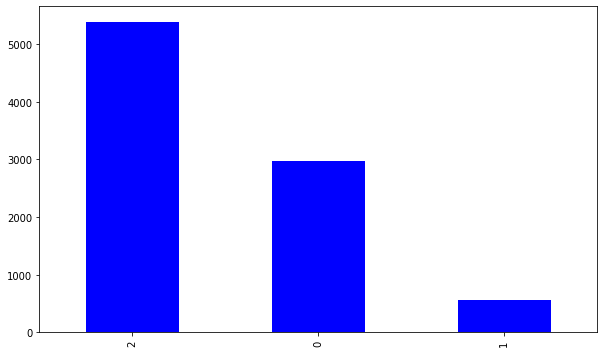

In [59]:
df['product_emotion'].value_counts().plot.bar(color = 'blue', figsize = (10, 6))

As we can see, neutral dominates the number of tweet emotions, so I am going to try to balance out the data out later

Next, let's take a look at the general distribution of tweets 

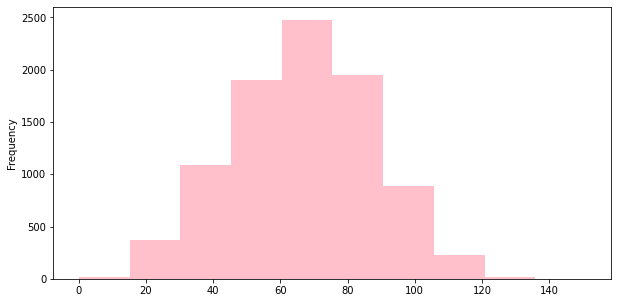

In [60]:
df['tweet_text'].str.len().plot.hist(color = 'pink', figsize = (10, 5))

Let's add a column representing the length of each tweet

In [61]:
df['tweet_len'] = df['tweet_text'].str.len()

In [62]:
df.head()

,tweet_text,device,product_emotion,tokens,tweet_len
0,wesley83 3g iphone hr tweeting rise_austin dea...,iPhone,1,"[iphone, hr, tweeting, dead, need, upgrade, pl...",80
1,jessedee know fludapp awesome ipad iphone app ...,iPad or iPhone App,0,"[jessedee, know, fludapp, awesome, ipad, iphon...",92
2,swonderlin wait ipad also sale sxsw,iPad,0,"[swonderlin, wait, ipad, also, sale, sxsw]",35
3,sxsw hope year festival crashy year iphone app...,iPad or iPhone App,1,"[sxsw, hope, year, festival, crashy, year, iph...",51
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,0,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",112


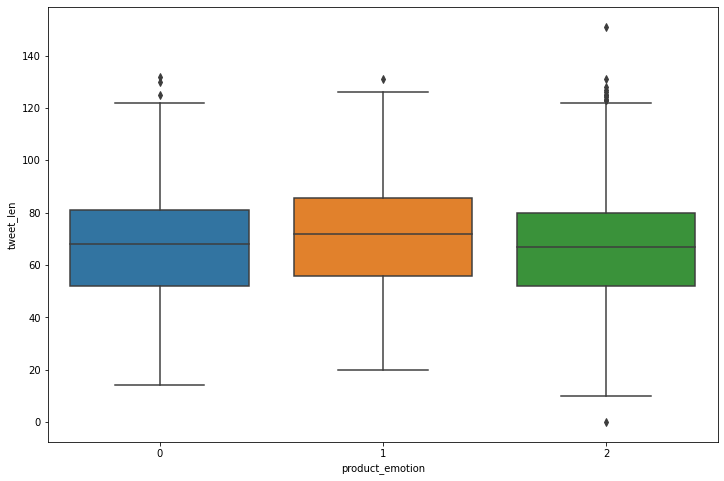

In [63]:
plt.figure(figsize = (12, 8))
sns.boxplot(x="product_emotion", y="tweet_len", data=df)

Now let's explore around with the tokens


In [64]:
# Create a new column for the token length
df['token_length'] = df['tokens'].str.len()

In [65]:
df.head()

,tweet_text,device,product_emotion,tokens,tweet_len,token_length
0,wesley83 3g iphone hr tweeting rise_austin dea...,iPhone,1,"[iphone, hr, tweeting, dead, need, upgrade, pl...",80,9
1,jessedee know fludapp awesome ipad iphone app ...,iPad or iPhone App,0,"[jessedee, know, fludapp, awesome, ipad, iphon...",92,14
2,swonderlin wait ipad also sale sxsw,iPad,0,"[swonderlin, wait, ipad, also, sale, sxsw]",35,6
3,sxsw hope year festival crashy year iphone app...,iPad or iPhone App,1,"[sxsw, hope, year, festival, crashy, year, iph...",51,9
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,0,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",112,17


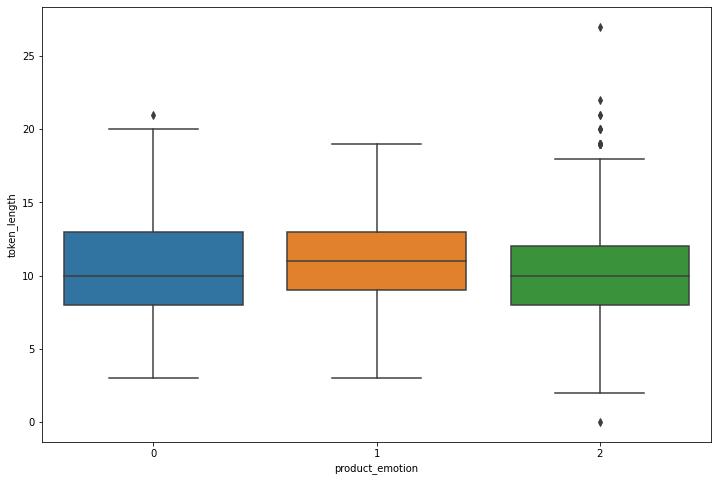

In [66]:
plt.figure(figsize = (12, 8))
sns.boxplot(x="product_emotion", y="token_length", data=df)

Top 20 Most Popular Words

In [67]:
most_freq_tweet_words_modified = FreqDist(tokens_concat_new)
word_frequency = most_freq_tweet_words_modified.most_common(20)

In [68]:
word_frequency

[('sxsw', 9372),
 ('google', 2594),
 ('ipad', 2457),
 ('apple', 2281),
 ('quot', 1657),
 ('iphone', 1541),
 ('store', 1498),
 ('new', 1078),
 ('austin', 949),
 ('amp', 834),
 ('app', 815),
 ('launch', 685),
 ('circle', 666),
 ('social', 637),
 ('android', 588),
 ('today', 576),
 ('network', 467),
 ('get', 451),
 ('line', 432),
 ('via', 428)]

Text(0.5, 1.0, 'Top 20 Most Common Words')

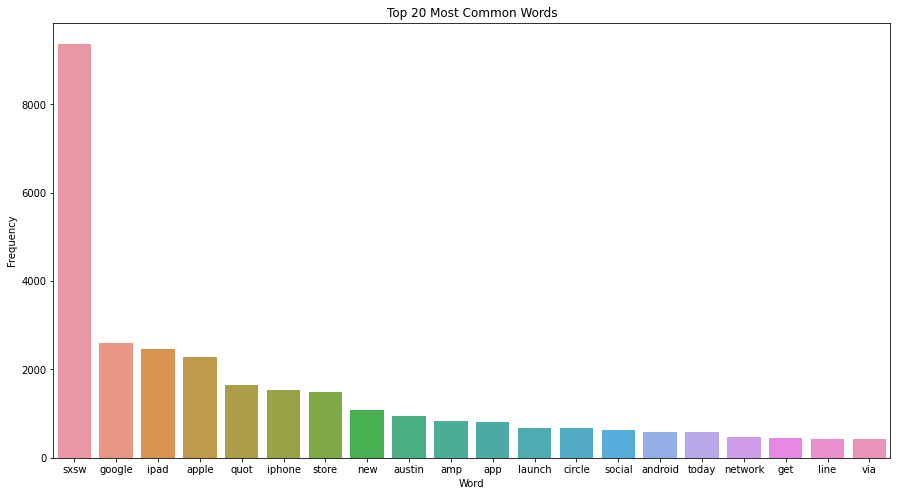

In [69]:
plt.figure(figsize = (15, 8))

freq  = [x[1] for x in word_frequency] 
words = [x[0] for x in word_frequency]

ax = sns.barplot(data=df, x= words, y = freq)
ax.set(xlabel='Word')
ax.set(ylabel='Frequency')
ax.set_title('Top 20 Most Common Words')

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

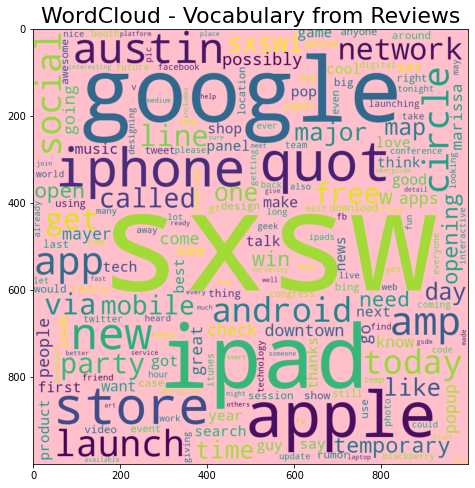

In [70]:
wordcloud = WordCloud(background_color = 'pink', width = 1000, height = 1000).generate_from_frequencies(most_freq_tweet_words_modified)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

Let's incorporate the module WordCloud now to observe for the most common words with respect to the product emotions

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

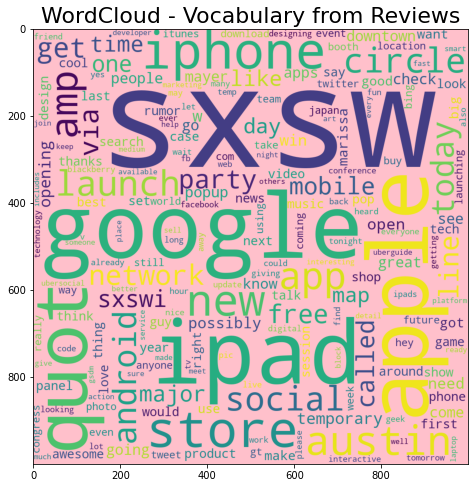

In [71]:
# Wordcloud takes in a dictionary as the input
wordcloud = WordCloud(background_color = 'pink', width = 1000, height = 1000).generate_from_frequencies(most_freq_tweet_words_modified)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

Now let's observe for the most popular words that had a positive emotion for the product rating

In [72]:
positive = df[df['product_emotion'] == 0]

In [73]:
positive.head()

,tweet_text,device,product_emotion,tokens,tweet_len,token_length
1,jessedee know fludapp awesome ipad iphone app ...,iPad or iPhone App,0,"[jessedee, know, fludapp, awesome, ipad, iphon...",92,14
2,swonderlin wait ipad also sale sxsw,iPad,0,"[swonderlin, wait, ipad, also, sale, sxsw]",35,6
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,0,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",112,17
7,sxsw starting ctia around corner googleio hop ...,Android,0,"[sxsw, starting, ctia, around, corner, googlei...",77,13
8,beautifully smart simple idea madebymany thene...,iPad or iPhone App,0,"[beautifully, smart, simple, idea, madebymany,...",101,15


In [74]:
pos_tweets = []
for word in positive['tokens']:
    pos_tweets += word

In [75]:
selected_words = ['mention', 'link', 'rt', 'i', 'u', 'user']
pos_tokens_concat = []
for word in pos_tweets:  # iterating on a copy since removing will mess things up
    if word not in selected_words:
        pos_tokens_concat.append(word)

In [76]:
most_freq_tweet_words_pos = FreqDist(pos_tokens_concat)
most_freq_tweet_words_pos.most_common(20)

[('sxsw', 3110),
 ('ipad', 1021),
 ('apple', 928),
 ('google', 727),
 ('store', 557),
 ('iphone', 544),
 ('quot', 464),
 ('app', 399),
 ('new', 359),
 ('austin', 294),
 ('amp', 211),
 ('android', 206),
 ('get', 181),
 ('launch', 174),
 ('party', 152),
 ('one', 149),
 ('line', 144),
 ('great', 137),
 ('time', 137),
 ('via', 132)]

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

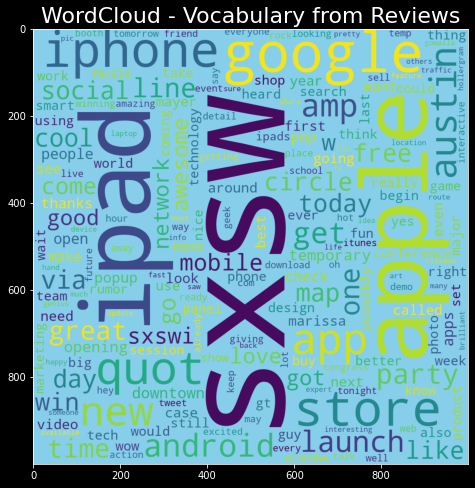

In [77]:
wordcloud = WordCloud(background_color = 'skyblue', width = 1000, height = 1000).generate_from_frequencies(most_freq_tweet_words_pos)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

Now for the negative emotions

In [78]:
negative = df[df['product_emotion'] == 1]

In [79]:
neg_tweets = []
for word in negative['tokens']:
    neg_tweets += word

In [80]:
selected_words = ['mention', 'link', 'rt', 'i', 'u', 'user']
neg_tokens_concat = []
for word in neg_tweets:  # iterating on a copy since removing will mess things up
    if word not in selected_words:
        neg_tokens_concat.append(word)

In [81]:
most_freq_tweet_words_neg = FreqDist(neg_tokens_concat)
most_freq_tweet_words_neg.most_common(20)

[('sxsw', 585),
 ('ipad', 194),
 ('quot', 175),
 ('iphone', 162),
 ('google', 150),
 ('apple', 121),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('circle', 37),
 ('need', 35),
 ('social', 31),
 ('apps', 30),
 ('design', 29),
 ('people', 29),
 ('get', 25),
 ('android', 24),
 ('austin', 24),
 ('one', 23)]

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

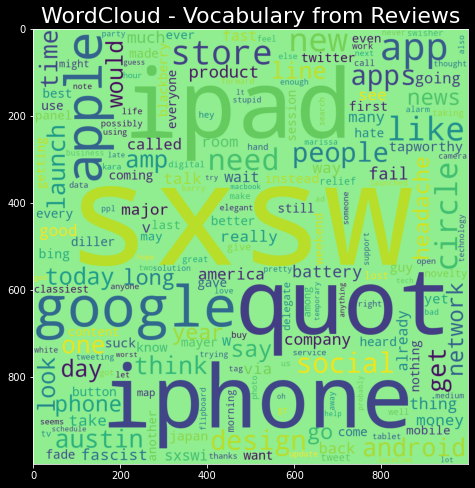

In [82]:
wordcloud = WordCloud(background_color = 'lightgreen', width = 1000, height = 1000).generate_from_frequencies(most_freq_tweet_words_neg)
plt.style.use('dark_background')
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

In [83]:
neutral = df[df['product_emotion'] == 2]

In [84]:
neut_tweets = []
for word in neutral['tokens']:
    neut_tweets += word

In [85]:
selected_words = ['mention', 'link', 'rt', 'i', 'u', 'user']
neut_tokens_concat = []
for word in neut_tweets:  # iterating on a copy since removing will mess things up
    if word not in selected_words:
        neut_tokens_concat.append(word)

In [86]:
most_freq_tweet_words_neut = FreqDist(neut_tokens_concat)
most_freq_tweet_words_neut.most_common(20)

[('sxsw', 5677),
 ('google', 1717),
 ('ipad', 1242),
 ('apple', 1232),
 ('quot', 1018),
 ('store', 894),
 ('iphone', 835),
 ('new', 676),
 ('austin', 631),
 ('amp', 601),
 ('circle', 507),
 ('launch', 489),
 ('social', 482),
 ('today', 441),
 ('android', 358),
 ('network', 358),
 ('app', 356),
 ('via', 282),
 ('called', 277),
 ('line', 268)]

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

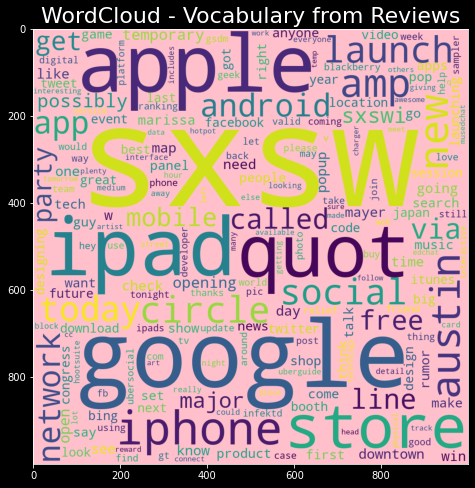

In [87]:
wordcloud = WordCloud(background_color = 'pink', width = 1000, height = 1000).generate_from_frequencies(most_freq_tweet_words_neut)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

In the final section of this EDA, let's explore the top 20 most popular hashtags

In [88]:
# Function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [89]:
hashtags = hashtag_extract(hashtag_df['tweet_text'])
total_hashtags = sum(hashtags,[])

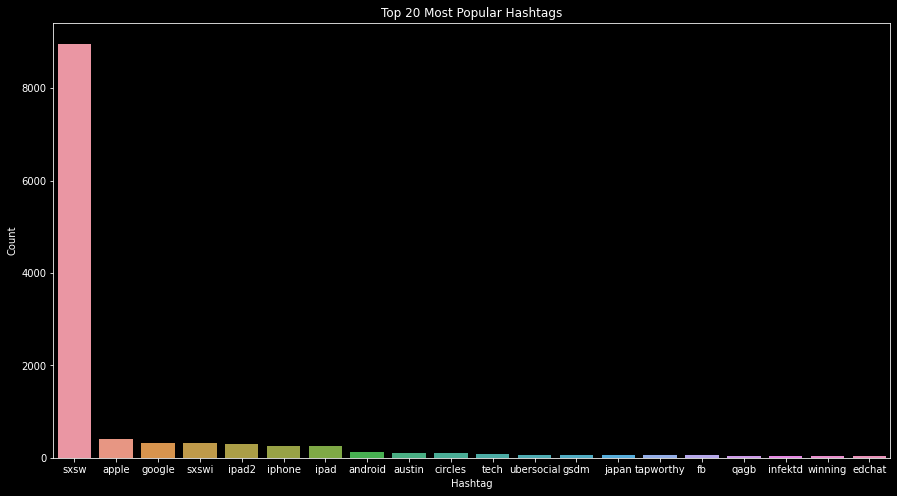

In [90]:
a = nltk.FreqDist(total_hashtags)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize = (15, 8))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
ax.set_title('Top 20 Most Popular Hashtags')
plt.show()

# <b>3) Feature Engineering</b>

<b>3.1) Bigrams/N-grams</b>

Knowing individual word frequencies is somewhat informative, but in practice, some of these tokens are actually parts of larger phrases that should be treated as a single unit. Let's create some bigrams, and see which combinations of words are most telling.

In [91]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [92]:
# Need to create a finder
tweet_finder = BigramCollocationFinder.from_words(tokens_concat_new)

In [93]:
# Compute bigram scores, so we can see the combinations that occur most frequently
tweet_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

In [94]:
# Output top 100 frequent pairs of words
tweet_scored[:100]

[(('apple', 'store'), 0.007688848427679854),
 (('sxsw', 'google'), 0.005528073619901065),
 (('sxsw', 'apple'), 0.0050783692182821295),
 (('social', 'network'), 0.004935780017768808),
 (('new', 'social'), 0.004529949216307817),
 (('store', 'sxsw'), 0.003838940013820184),
 (('austin', 'sxsw'), 0.003597635212951487),
 (('google', 'launch'), 0.0035866668129120004),
 (('network', 'called'), 0.0035098880126355966),
 (('called', 'circle'), 0.0034331092123591933),
 (('iphone', 'app'), 0.0031918044114904957),
 (('major', 'new'), 0.0031918044114904957),
 (('launch', 'major'), 0.003104057211174606),
 (('ipad', 'sxsw'), 0.003016310010858716),
 (('sxsw', 'ipad'), 0.0029834048107402573),
 (('today', 'sxsw'), 0.002785973610029505),
 (('sxsw', 'sxsw'), 0.002610479209397725),
 (('possibly', 'today'), 0.00256660560923978),
 (('circle', 'possibly'), 0.0025446688091608077),
 (('apple', 'opening'), 0.002467890008884404),
 (('sxsw', 'quot'), 0.002369174408529028),
 (('google', 'circle'), 0.00229239560825262

Upon first glance, I noticed that 'sxsw' pairs up with another word very frequently. Sxsw was shown to be a hashtag in the original uncleaned data set, so this is definitely a very important hashtag/word to keep track of. Apple and google pops up frequently too (no surprise here) and also the devices made by Apple such as 'iphone' and 'ipad' show up frequently too. Let's explore a bit further and observe the top fifty 3 word combinations

In [95]:
# Import ngrams 
from nltk.util import ngrams

In [96]:
# Convert the tokens_concat_new list into a series and output the top 50 3-worded combination
(pd.Series(nltk.ngrams(tokens_concat_new, 3)).value_counts(normalize = True))[:50]

(new, social, network)          0.004234
(social, network, called)       0.003510
(network, called, circle)       0.003378
(major, new, social)            0.003192
(launch, major, new)            0.003104
(google, launch, major)         0.002907
(circle, possibly, today)       0.002545
(called, circle, possibly)      0.002512
(apple, store, sxsw)            0.001898
(store, downtown, austin)       0.001777
(possibly, today, sxsw)         0.001744
(sxsw, apple, store)            0.001689
(downtown, austin, sxsw)        0.001382
(opening, temporary, store)     0.001272
(apple, opening, temporary)     0.001261
(sxsw, google, launch)          0.001185
(temporary, store, downtown)    0.001075
(store, austin, sxsw)           0.000910
(austin, sxsw, ipad)            0.000877
(sxsw, ipad, launch)            0.000856
(iphone, app, store)            0.000812
(today, sxsw, google)           0.000790
(includes, uberguide, sxsw)     0.000746
(ubersocial, iphone, app)       0.000746
(new, ubersocial

The hashtag 'sxsw' and apple and google still appear frequently, but now words relating to locations (like downtown and Austin) seem to appear more often now. 

<b>3.2) Mutual Information Scores</b>

Mutual Information scores is an extension of bigrams as it measures the mutual dependence between two words. We will set up a frequency filter and a threshold of 10, representing the minimum number of times a bigram combination must occur.

In [97]:
# Initialize finder
tweet_mi_finder = BigramCollocationFinder.from_words(tokens_concat_new)

In [98]:
# Set a threshold value of 10 
tweet_mi_finder.apply_freq_filter(10)

In [99]:
tweet_mi_scored = tweet_mi_finder.score_ngrams(bigram_measures.pmi)

In [100]:
tweet_mi_scored[:50]

[(('charles', 'chen'), 13.154359284386578),
 (('ice', 'cream'), 12.668932457216336),
 (('lustre', 'pearl'), 12.569396783665422),
 (('dwnld', 'groundlink'), 12.476287379273941),
 (('lonely', 'planet'), 12.46248157974891),
 (('false', 'alarm'), 12.3888245380236),
 (('augmented', 'reality'), 12.228359865830356),
 (('til', 'midnight'), 12.190885160411693),
 (('speech', 'therapy'), 12.15435928438658),
 (('holler', 'gram'), 12.083969956495176),
 (('league', 'extraordinary'), 11.949741564778103),
 (('therapy', 'communication'), 11.891324878552783),
 (('communication', 'showcased'), 11.849504702858157),
 (('maggie', 'mae'), 11.832431189499216),
 (('mike', 'tyson'), 11.832431189499216),
 (('interrupt', 'regularly'), 11.775847661132847),
 (('afford', 'attend'), 11.76008034527453),
 (('regularly', 'scheduled'), 11.668932457216336),
 (('south', 'southwest'), 11.668932457216336),
 (('red', 'cross'), 11.650316779048989),
 (('mark', 'belinsky'), 11.644603127854593),
 (('exhibit', 'hall'), 11.63079732

We notice here that the bigrams are pretty randomly spread out, with no clear indication of what the bigrams are talking about. The bigrams also doesn't seem to really be talking about tech-related content.

<b>3.3 Text Vectorization</b>

Before we proceed on to the modelling stage, we first need to vectorize our data set because machines can only recognize numerical values, not text data. There are several different methods to vectorize the data set, including CountVectorization, TF-IDF, and word2vec. For this scenario, I will elect to use the  TF-IDF. Count vectorization counts the number of times a word matches a word in the english dictionary but does not take into account the context behind words. For example, if we were looking at a sentence that was 'Today is a beautiful day', the context behind the sentence would be a happy/positive mood. What words generate this positive mood? You would probably say beautiful. In Count vectorization, the word 'a' would be treated with equal value as the word 'beautiful'. TF-IDF solves this issue by assigning a score to words by normalizing them. Essentially, TD-IDF highlights each word’s relevance in the entire document. 

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
# try different min_df values
vectorizer = TfidfVectorizer(min_df= 5)
analyzer = vectorizer.fit_transform(df.tweet_text)

In [102]:
print(len(df.tweet_text))

8936


In [103]:
df_transformed = pd.DataFrame(analyzer.toarray(), columns = vectorizer.get_feature_names())

In [104]:
df_transformed

,00,000,03,10,100,101,11,12,13,14,1415,15,150,150m,16,16gb,18,19,1986,1pm,1st,20,200,2011,22,23,24,25,2nd,30,300,30pm,35,3d,3g,3gs,3rd,40,437,45,...,xperia,ya,yahoo,yay,yeah,year,yelp,yep,yes,yesterday,yet,york,you,yourmom,youtube,yr,yup,zaarly,zappos,zazzle,zazzlesxsw,zazzlsxsw,zlf,zomb,zombie,zomg,ã_,åç,û_,ûª,ûªll,ûªm,ûªre,ûªs,ûªt,ûï,ûïcheck,ûò,ûòand,ûó
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35481,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.701936,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.348452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


#<b>4) Modelling</b>

In the final section, I will explore a variety of modelling algorithms including logistic regression and neural networks. I will also incorporate the usage of PCA, which is a dimensionality reduction technique which serves to improve the accuracy of a classification task by reducing unnecessary features.

In [105]:
X = df_transformed
y = df['product_emotion']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [107]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6702, 2229)
(2234, 2229)
(6702,)
(2234,)


In [108]:
# Import StandardScaler
# do not center the data, because centering them entails building a dense matrix which in 
# common use cases is likely to be too large to fit in memory
sc = StandardScaler(with_mean=False) 
x_train_scaled = sc.fit_transform(X_train)
x_test_scaled = sc.fit_transform(X_test)

<b>Model #1: Multinomial Naive Bayes classifier</b>

In [109]:
nb_classifier = MultinomialNB()
nb_classifier.fit(x_train_scaled, y_train)

y_pred = nb_classifier.predict(x_test_scaled)

print('Naive Bayes Multinomial Classifier')
print('-' * 40)
print("Training Accuracy :", nb_classifier.score(x_train_scaled, y_train))
print("Testing Accuracy :", nb_classifier.score(x_test_scaled, y_test))

Naive Bayes Multinomial Classifier
----------------------------------------
Training Accuracy : 0.7302297821545807
Testing Accuracy : 0.5801253357206804


As you can see, although this model predicted better than random guessing (33% is considered random guessing because we have 3 classes), but the accuracy can definitely be improved. Let's take a look at logistic regression.

<b>Model #2: Logistic Regression Base Model</b>





In [110]:
log_classifier = LogisticRegression()
log_classifier.fit(x_train_scaled, y_train)

y_pred = log_classifier.predict(x_test_scaled)

print('Logistic Regression Classifier')
print('-' * 40)
print("Training Accuracy :", log_classifier.score(x_train_scaled, y_train))
print("Testing Accuracy :", log_classifier.score(x_test_scaled, y_test))

Logistic Regression Classifier
----------------------------------------
Training Accuracy : 0.9024171888988362
Testing Accuracy : 0.6114592658907789


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<b>Model #3: Random Forest Base Model</b>



In [111]:
forest_classifier = RandomForestClassifier()
forest_classifier.fit(x_train_scaled, y_train)

y_pred = forest_classifier.predict(x_test_scaled)

print('Random Forest Classifier')
print('-' * 40)
print("Training Accuracy :", forest_classifier.score(x_train_scaled, y_train))
print("Testing Accuracy :", forest_classifier.score(x_test_scaled, y_test))

Random Forest Classifier
----------------------------------------
Training Accuracy : 0.9574753804834378
Testing Accuracy : 0.6794986571172784


<b>Model #4: Support Vector Classification

In [112]:
svc_classifier = SVC()
svc_classifier.fit(x_train_scaled, y_train)

y_pred = svc_classifier.predict(x_test_scaled)

print('Support Vector Classifier')
print('-' * 40)
print("Training Accuracy :", svc_classifier.score(x_train_scaled, y_train))
print("Testing Accuracy :", svc_classifier.score(x_test_scaled, y_test))

Support Vector Classifier
----------------------------------------
Training Accuracy : 0.8637720083557147
Testing Accuracy : 0.6714413607878246


It seems that the best model so far is the random forest model, so we will perform some hyperparameter tuning to see if we can boost up the accuracy before we dive into the neural networks. There are two types of hyperparameter tuning: Grid Search Cross Validation and Randomized Search. Both are similar methods but Randomized outputs results much faster. We will experiment with both because they don't necessarily produce the same results.

In [113]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings!


In [114]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(x_train_scaled, y_train)

In [115]:
# # Random Forest Model Tuned
# forest_classifier = RandomForestClassifier(bootstrap=True,
#                                                     ccp_alpha=0.0,
#                                                     class_weight=None,
#                                                     criterion='gini',
#                                                     max_depth=None,
#                                                     max_features='auto',
#                                                     max_leaf_nodes=None,
#                                                     max_samples=None,
#                                                     min_impurity_decrease=0.0,
#                                                     min_impurity_split=None,
#                                                     min_samples_leaf=1,
#                                                     min_samples_split=2,
#                                                     min_weight_fraction_leaf=0.0,
#                                                     n_estimators=100)
# forest_classifier.fit(x_train_scaled, y_train)

# y_pred = forest_classifier.predict(x_test_scaled)

# print('Random Forest Classifier')
# print('-' * 40)
# print("Training Accuracy :", forest_classifier.score(x_train_scaled, y_train))
# print("Testing Accuracy :", forest_classifier.score(x_test_scaled, y_test))

The tuned random forest model did not improve the accuracy score at all, but the model still does much better than random guessing (33% versus 67%). Let's explore neural networks now.

<b>Model #5: Neural Network Base Model</b>

We need to first one-hot encode our target variable before we start modelling

In [116]:
# Initialize
le = preprocessing.LabelEncoder() 
le.fit(y)
print('Original class labels:')
print(list(le.classes_))
print('\n')
product_cat = le.transform(y)  

# If you wish to retrieve the original descriptive labels post production
# list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) 

print('New product labels:')
print(product_cat)
print('\n')

# Each row will be all zeros except for the category for that observation 
print('One hot labels; 3 binary columns, one for each of the categories.') 
product_onehot = to_categorical(product_cat)
print(product_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(product_onehot))


Original class labels:
[0, 1, 2]


New product labels:
[1 0 0 ... 2 2 2]


One hot labels; 3 binary columns, one for each of the categories.
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


One hot labels shape:
(8936, 3)


Before we build a neural network, I will split the data into training and testing sets. I also need to convert the data frame into a dense version, as neural networks modelling does not look favourably upon sparse matrices.

In [117]:
vect_df = pd.DataFrame(analyzer.todense(), columns = vectorizer.get_feature_names())

In [118]:
vect_df

,00,000,03,10,100,101,11,12,13,14,1415,15,150,150m,16,16gb,18,19,1986,1pm,1st,20,200,2011,22,23,24,25,2nd,30,300,30pm,35,3d,3g,3gs,3rd,40,437,45,...,xperia,ya,yahoo,yay,yeah,year,yelp,yep,yes,yesterday,yet,york,you,yourmom,youtube,yr,yup,zaarly,zappos,zazzle,zazzlesxsw,zazzlsxsw,zlf,zomb,zombie,zomg,ã_,åç,û_,ûª,ûªll,ûªm,ûªre,ûªs,ûªt,ûï,ûïcheck,ûò,ûòand,ûó
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35481,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.701936,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.348452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [119]:
# Produces test split.
x_train, x_val, y_train, y_val = train_test_split(vect_df, product_onehot, test_size=0.25, random_state = 1)

In [120]:
sc = StandardScaler(with_mean=False) 
x_train_scaled_1 = sc.fit_transform(x_train)
x_val_scaled_1 = sc.fit_transform(x_val)

In [121]:
print(x_train_scaled_1.shape)
print(x_val_scaled_1.shape)
print(y_train.shape)
print(y_val.shape)

(6702, 2229)
(2234, 2229)
(6702, 3)
(2234, 3)


In [122]:
type(x_train_scaled_1)

numpy.ndarray

In [123]:
# Neural Network
model = models.Sequential()
model.add(layers.Dense(50, activation = 'relu', input_shape = (2229, )))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

Now let's build our base model 

In [124]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                111500    
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 78        
Total params: 112,853
Trainable params: 112,853
Non-trainable params: 0
_________________________________________________________________


In [125]:
results_1 = model.fit(x_train_scaled_1, y_train, 
                         epochs = 100, batch_size = 32, validation_data = (x_val_scaled_1, y_val))

Epoch 1/100
210/210 [==============================] - 1s 4ms/step - loss: 0.8368 - accuracy: 0.6076 - val_loss: 0.7698 - val_accuracy: 0.6415
Epoch 2/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4908 - accuracy: 0.7978 - val_loss: 0.8025 - val_accuracy: 0.6486
Epoch 3/100
210/210 [==============================] - 1s 3ms/step - loss: 0.3426 - accuracy: 0.8690 - val_loss: 0.8807 - val_accuracy: 0.6392
Epoch 4/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2637 - accuracy: 0.8978 - val_loss: 0.9665 - val_accuracy: 0.6504
Epoch 5/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2294 - accuracy: 0.9087 - val_loss: 1.0419 - val_accuracy: 0.6589
Epoch 6/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2021 - accuracy: 0.9172 - val_loss: 1.0643 - val_accuracy: 0.6477
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 0.1887 - accuracy: 0.9236 - val_loss: 1.1038 - val_accuracy: 0.6517

In [126]:
training_score = model.evaluate(x_train_scaled_1, y_train)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = model.evaluate(x_val_scaled_1, y_val)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.0749 - accuracy: 0.9563
Training Loss: 0.0749 
Training Accuracy: 0.956
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 2.8771 - accuracy: 0.6303
Test Loss: 2.88 
Test Accuracy: 0.63


In [127]:
#Accepts the results from the fitted model and outputs a visualization of the 
# loss and accuracy score based on the validation set
def visualize_training_results(results):

    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

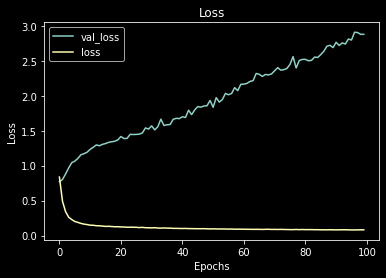

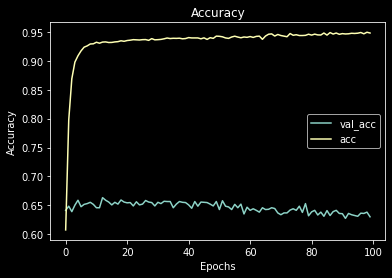

In [128]:
visualize_training_results(results_1)

It looks like our network is overfitting as you can see from the validation set. To avoid this issue, we can decrease the number of nodes, or decrease the number of layers, or apply a regularization technique which we will do soon for the next model. For now, let's play around with the nodes and layers.

In [129]:
# Decrease the number of nodes
decreased_nodes_model = models.Sequential()
decreased_nodes_model.add(layers.Dense(30, activation = 'relu', input_shape = (2229, )))
decreased_nodes_model.add(layers.Dense(5, activation='relu'))
decreased_nodes_model.add(layers.Dense(3, activation='softmax'))

decreased_nodes_model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [130]:
decreased_nodes_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                66900     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 155       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 18        
Total params: 67,073
Trainable params: 67,073
Non-trainable params: 0
_________________________________________________________________


In [131]:
results_2 = decreased_nodes_model.fit(x_train_scaled_1, y_train, 
                         epochs = 100, batch_size = 32, validation_data = (x_val_scaled_1, y_val))

Epoch 1/100
210/210 [==============================] - 1s 4ms/step - loss: 0.8970 - accuracy: 0.5646 - val_loss: 0.7827 - val_accuracy: 0.6446
Epoch 2/100
210/210 [==============================] - 1s 3ms/step - loss: 0.5658 - accuracy: 0.7538 - val_loss: 0.7985 - val_accuracy: 0.6589
Epoch 3/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4171 - accuracy: 0.8199 - val_loss: 0.8860 - val_accuracy: 0.6491
Epoch 4/100
210/210 [==============================] - 1s 3ms/step - loss: 0.3319 - accuracy: 0.8585 - val_loss: 0.9845 - val_accuracy: 0.6585
Epoch 5/100
210/210 [==============================] - 1s 2ms/step - loss: 0.2759 - accuracy: 0.8851 - val_loss: 1.0729 - val_accuracy: 0.6585
Epoch 6/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2342 - accuracy: 0.9029 - val_loss: 1.1925 - val_accuracy: 0.6571
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2121 - accuracy: 0.9106 - val_loss: 1.2628 - val_accuracy: 0.6504

In [132]:
training_score = decreased_nodes_model.evaluate(x_train_scaled_1, y_train)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = decreased_nodes_model.evaluate(x_val_scaled_1, y_val)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.0806 - accuracy: 0.9543
Training Loss: 0.0806 
Training Accuracy: 0.954
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 3.8653 - accuracy: 0.6235
Test Loss: 3.87 
Test Accuracy: 0.624


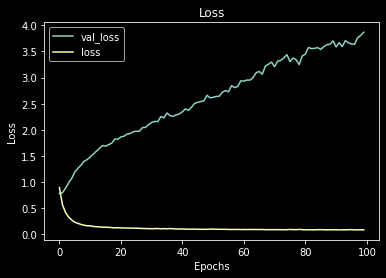

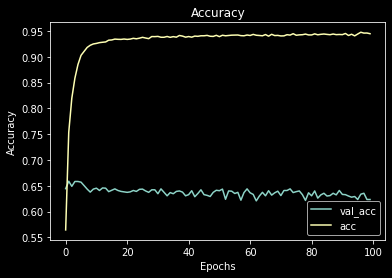

In [133]:
visualize_training_results(results_2)

The model did not improve at all, as you can see, the model is still being overfit. The accuracy essentially did not change as well. Now let's try getting rid of the second layer and just having 2 layers for the network

In [134]:
# 2 layer neural network
two_layer_model = models.Sequential()
two_layer_model.add(layers.Dense(30, activation = 'relu', input_shape = (2229, )))
two_layer_model.add(layers.Dense(3, activation='softmax'))

two_layer_model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [135]:
two_layer_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                66900     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 93        
Total params: 66,993
Trainable params: 66,993
Non-trainable params: 0
_________________________________________________________________


In [136]:
results_3 = two_layer_model.fit(x_train_scaled_1, y_train, 
                         epochs = 100, batch_size = 32, validation_data = (x_val_scaled_1, y_val))

Epoch 1/100
210/210 [==============================] - 1s 3ms/step - loss: 0.8793 - accuracy: 0.5988 - val_loss: 0.7995 - val_accuracy: 0.6535
Epoch 2/100
210/210 [==============================] - 1s 3ms/step - loss: 0.5085 - accuracy: 0.7865 - val_loss: 0.8337 - val_accuracy: 0.6647
Epoch 3/100
210/210 [==============================] - 1s 3ms/step - loss: 0.3762 - accuracy: 0.8533 - val_loss: 0.9197 - val_accuracy: 0.6585
Epoch 4/100
210/210 [==============================] - 1s 3ms/step - loss: 0.3054 - accuracy: 0.8857 - val_loss: 0.9886 - val_accuracy: 0.6495
Epoch 5/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2621 - accuracy: 0.9011 - val_loss: 1.0703 - val_accuracy: 0.6517
Epoch 6/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2370 - accuracy: 0.9088 - val_loss: 1.1381 - val_accuracy: 0.6517
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2199 - accuracy: 0.9158 - val_loss: 1.1694 - val_accuracy: 0.6603

In [137]:
training_score = two_layer_model.evaluate(x_train_scaled_1, y_train)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = two_layer_model.evaluate(x_val_scaled_1, y_val)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.0834 - accuracy: 0.9549
Training Loss: 0.0834 
Training Accuracy: 0.955
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 2.5193 - accuracy: 0.6356
Test Loss: 2.52 
Test Accuracy: 0.636


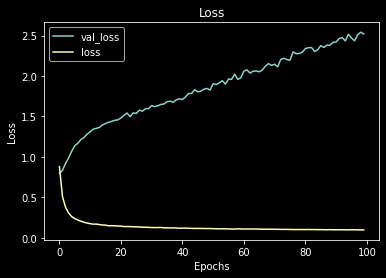

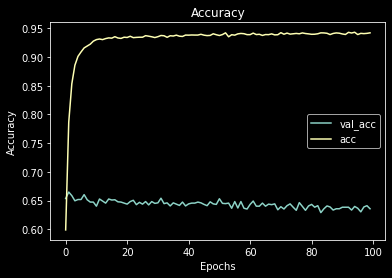

In [138]:
visualize_training_results(results_3)

Decreasing the nodes and deleting a layer virtually had no effect on the accuracy score of the model. Now, we will proceed on to the last model: a regualarized neural network with dropout.

<b>Model #6: Neural Network Regularized (with dropout)</b>


Regularization is a commonly used technique to reduce variance and prevents overfitting. Adding in a dropout layer will involve setting a certain proportion of units in each layer to zero. Before we do any regularization or adding dropout layers, let's first introduce a concept called Early Stopping. Essentially, this is a technique to prevent overfitting. You never know in advance how many epochs to include for your neural network, but using this technique will help give you an idea of when to stop training your model given the number of epochs. Having more epochs may not only be useless, but also time-consuming.

In [139]:
final_model = models.Sequential()
final_model.add(layers.Dense(25, activation = 'relu', input_shape = (2229, )))
final_model.add(layers.Dense(3, activation='softmax'))

final_model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [140]:
early_stopping = [EarlyStopping(monitor='val_loss', patience=30)]

In [141]:
results_4 = final_model.fit(x_train_scaled_1, y_train, 
                         epochs = 100, batch_size = 32, callbacks = early_stopping, validation_data = (x_val_scaled_1, y_val))

Epoch 1/100
210/210 [==============================] - 1s 4ms/step - loss: 0.9482 - accuracy: 0.5839 - val_loss: 0.7903 - val_accuracy: 0.6441
Epoch 2/100
210/210 [==============================] - 1s 3ms/step - loss: 0.5074 - accuracy: 0.7850 - val_loss: 0.8049 - val_accuracy: 0.6571
Epoch 3/100
210/210 [==============================] - 1s 3ms/step - loss: 0.3778 - accuracy: 0.8487 - val_loss: 0.8783 - val_accuracy: 0.6616
Epoch 4/100
210/210 [==============================] - 1s 3ms/step - loss: 0.3072 - accuracy: 0.8805 - val_loss: 0.9531 - val_accuracy: 0.6634
Epoch 5/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2619 - accuracy: 0.8981 - val_loss: 1.0288 - val_accuracy: 0.6638
Epoch 6/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2423 - accuracy: 0.9029 - val_loss: 1.0691 - val_accuracy: 0.6616
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 0.2169 - accuracy: 0.9132 - val_loss: 1.1264 - val_accuracy: 0.6553

In [142]:
training_score = final_model.evaluate(x_train_scaled_1, y_train)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = final_model.evaluate(x_val_scaled_1, y_val)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.1027 - accuracy: 0.9523
Training Loss: 0.103 
Training Accuracy: 0.952
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 1.6013 - accuracy: 0.6544
Test Loss: 1.6 
Test Accuracy: 0.654


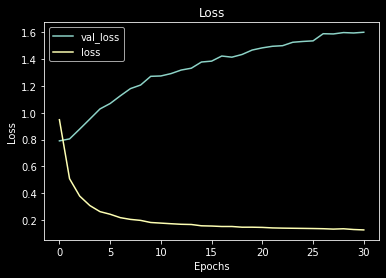

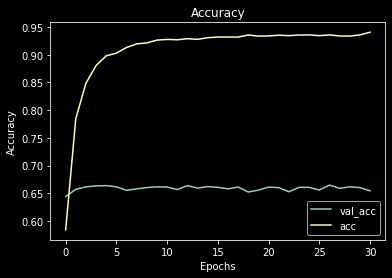

In [143]:
visualize_training_results(results_4)

Now let's see if we can apply regularization to reduce the overfitting, as there is still evidence of it occuring. There are two types of regularization techniques: L1 and L2. The main intuitive difference between the L1 and L2 regularization is that L1 regularization tries to estimate the median of the data while the L2 regularization tries to estimate the mean of the data to avoid overfitting. We will experiment with both techniques to see which one produces better results.

In [144]:
# L2 Regularization
final_model_L2 = models.Sequential()
final_model_L2.add(layers.Dense(25, activation = 'relu', kernel_regularizer=regularizers.l2(0.005), input_shape = (2229, )))
final_model_L2.add(layers.Dense(3, activation='softmax'))

final_model_L2.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [145]:
results_5 = final_model_L2.fit(x_train_scaled_1, y_train, 
                         epochs = 100, batch_size = 32, callbacks = early_stopping, validation_data = (x_val_scaled_1, y_val))

Epoch 1/100
210/210 [==============================] - 1s 3ms/step - loss: 0.9293 - accuracy: 0.6132 - val_loss: 0.8554 - val_accuracy: 0.6589
Epoch 2/100
210/210 [==============================] - 1s 3ms/step - loss: 0.6051 - accuracy: 0.7819 - val_loss: 0.8818 - val_accuracy: 0.6616
Epoch 3/100
210/210 [==============================] - 1s 2ms/step - loss: 0.5143 - accuracy: 0.8283 - val_loss: 0.9352 - val_accuracy: 0.6652
Epoch 4/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4630 - accuracy: 0.8551 - val_loss: 0.9884 - val_accuracy: 0.6589
Epoch 5/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4350 - accuracy: 0.8691 - val_loss: 1.0174 - val_accuracy: 0.6616
Epoch 6/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4103 - accuracy: 0.8806 - val_loss: 1.0719 - val_accuracy: 0.6647
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 0.3905 - accuracy: 0.8929 - val_loss: 1.1070 - val_accuracy: 0.6585

In [146]:
training_score = final_model_L2.evaluate(x_train_scaled_1, y_train)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = final_model_L2.evaluate(x_val_scaled_1, y_val)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.2618 - accuracy: 0.9391
Training Loss: 0.262 
Training Accuracy: 0.939
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 1.3617 - accuracy: 0.6656
Test Loss: 1.36 
Test Accuracy: 0.666


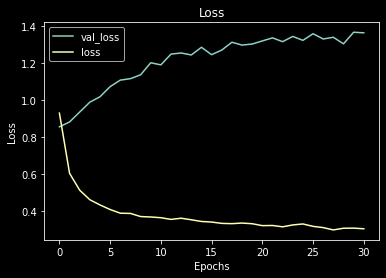

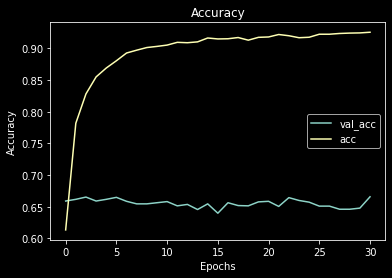

In [147]:
visualize_training_results(results_5)

The results are quite disappointing! L2 does not seem to have any effect; it actually decreased the accuracy score so let's try l1 now!

In [148]:
# L1 Regularization
final_model_L1 = models.Sequential()
final_model_L1.add(layers.Dense(25, activation = 'relu', kernel_regularizer=regularizers.l1(0.005), input_shape = (2229, )))
final_model_L1.add(layers.Dense(3, activation='softmax'))

final_model_L1.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [149]:
results_6 = final_model_L1.fit(x_train_scaled_1, y_train, 
                         epochs = 100, batch_size = 32, callbacks = early_stopping, validation_data = (x_val_scaled_1, y_val))

Epoch 1/100
210/210 [==============================] - 1s 4ms/step - loss: 2.4857 - accuracy: 0.5921 - val_loss: 1.3807 - val_accuracy: 0.6392
Epoch 2/100
210/210 [==============================] - 1s 3ms/step - loss: 1.2310 - accuracy: 0.6791 - val_loss: 1.2403 - val_accuracy: 0.6611
Epoch 3/100
210/210 [==============================] - 1s 3ms/step - loss: 1.1872 - accuracy: 0.6889 - val_loss: 1.2414 - val_accuracy: 0.6571
Epoch 4/100
210/210 [==============================] - 1s 3ms/step - loss: 1.1581 - accuracy: 0.6976 - val_loss: 1.2356 - val_accuracy: 0.6562
Epoch 5/100
210/210 [==============================] - 1s 3ms/step - loss: 1.1137 - accuracy: 0.7096 - val_loss: 1.2046 - val_accuracy: 0.6683
Epoch 6/100
210/210 [==============================] - 1s 3ms/step - loss: 1.0547 - accuracy: 0.7238 - val_loss: 1.1678 - val_accuracy: 0.6611
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 1.0439 - accuracy: 0.7296 - val_loss: 1.1505 - val_accuracy: 0.6562

In [150]:
training_score = final_model_L1.evaluate(x_train_scaled_1, y_train)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = final_model_L1.evaluate(x_val_scaled_1, y_val)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.7495 - accuracy: 0.8308
Training Loss: 0.75 
Training Accuracy: 0.831
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 1.1337 - accuracy: 0.6732
Test Loss: 1.13 
Test Accuracy: 0.673


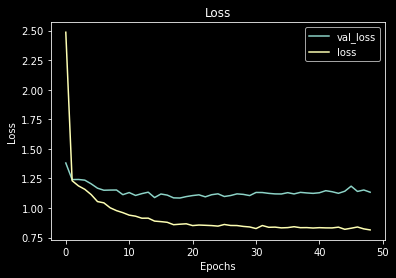

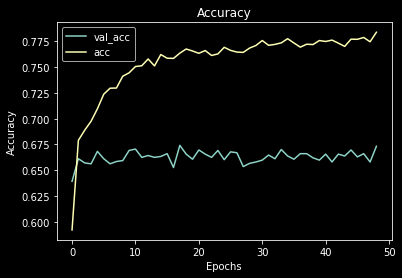

In [151]:
visualize_training_results(results_6)

The L1 regularization improved the score slightly, but it is still overfitted. Let's apply dropout now to the model.

In [152]:
# L1 Regularization
final_model_L1_dropout = models.Sequential()
final_model_L1_dropout.add(layers.Dropout(0.2, input_shape = (2229, )))
final_model_L1_dropout.add(layers.Dense(25, activation = 'relu', kernel_regularizer=regularizers.l1(0.003)))
final_model_L1_dropout.add(layers.Dropout(0.2))
final_model_L1_dropout.add(layers.Dense(3, activation='softmax'))

final_model_L1_dropout.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [153]:
results_7 = final_model_L1_dropout.fit(x_train_scaled_1, y_train, 
                         epochs = 100, batch_size = 32, callbacks = early_stopping, validation_data = (x_val_scaled_1, y_val))

Epoch 1/100
210/210 [==============================] - 1s 5ms/step - loss: 2.0569 - accuracy: 0.5839 - val_loss: 1.4653 - val_accuracy: 0.6441
Epoch 2/100
210/210 [==============================] - 1s 4ms/step - loss: 1.3353 - accuracy: 0.6749 - val_loss: 1.3205 - val_accuracy: 0.6517
Epoch 3/100
210/210 [==============================] - 1s 4ms/step - loss: 1.2457 - accuracy: 0.6720 - val_loss: 1.2598 - val_accuracy: 0.6665
Epoch 4/100
210/210 [==============================] - 1s 4ms/step - loss: 1.2106 - accuracy: 0.6774 - val_loss: 1.2606 - val_accuracy: 0.6549
Epoch 5/100
210/210 [==============================] - 1s 4ms/step - loss: 1.2063 - accuracy: 0.6777 - val_loss: 1.2390 - val_accuracy: 0.6540
Epoch 6/100
210/210 [==============================] - 1s 4ms/step - loss: 1.1903 - accuracy: 0.6792 - val_loss: 1.2548 - val_accuracy: 0.6540
Epoch 7/100
210/210 [==============================] - 1s 4ms/step - loss: 1.1693 - accuracy: 0.6825 - val_loss: 1.2274 - val_accuracy: 0.6585

In [154]:
training_score = final_model_L1_dropout.evaluate(x_train_scaled_1, y_train)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = final_model_L1_dropout.evaluate(x_val_scaled_1, y_val)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.8633 - accuracy: 0.7933
Training Loss: 0.863 
Training Accuracy: 0.793
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 1.1336 - accuracy: 0.6683
Test Loss: 1.13 
Test Accuracy: 0.668


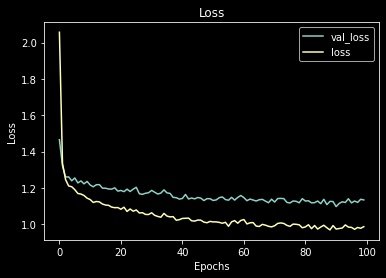

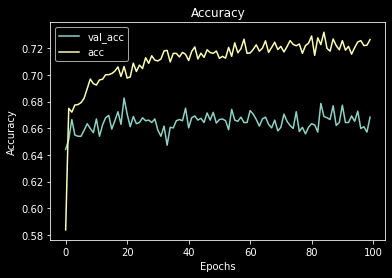

In [155]:
visualize_training_results(results_7)

Overall, the results have been pretty disappointing for the neural networks. There is one last resort to hopefully bump up the accuracy score and preventing overfitting

In [156]:
# Generating extra data
df_bigger_sample = df.sample(50000, replace=True)
x_train_bigger, x_val_bigger, y_train_bigger, y_val_bigger = train_test_split(X, product_onehot, test_size=0.25, random_state = 42)

In [157]:
sc = StandardScaler(with_mean=False) 
x_train_bigger_scaled= sc.fit_transform(x_train_bigger)
x_val_bigger_scaled = sc.fit_transform(x_val_bigger)

In [158]:
# L1 Regularization
final_model_L1_dropout_1 = models.Sequential()
final_model_L1_dropout_1.add(layers.Dropout(0.2, input_shape = (2229, )))
final_model_L1_dropout_1.add(layers.Dense(25, activation = 'relu', kernel_regularizer=regularizers.l1(0.003)))
final_model_L1_dropout_1.add(layers.Dropout(0.2))
final_model_L1_dropout_1.add(layers.Dense(3, activation='softmax'))

final_model_L1_dropout_1.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [159]:
results_8 = final_model_L1_dropout_1.fit(x_train_bigger_scaled, y_train_bigger, 
                         epochs = 100, batch_size = 32, callbacks = early_stopping, validation_data = (x_val_bigger_scaled, y_val_bigger))

Epoch 1/100
210/210 [==============================] - 1s 6ms/step - loss: 2.2042 - accuracy: 0.5549 - val_loss: 1.5358 - val_accuracy: 0.6383
Epoch 2/100
210/210 [==============================] - 1s 4ms/step - loss: 1.3445 - accuracy: 0.6728 - val_loss: 1.3291 - val_accuracy: 0.6495
Epoch 3/100
210/210 [==============================] - 1s 4ms/step - loss: 1.2220 - accuracy: 0.6938 - val_loss: 1.2944 - val_accuracy: 0.6562
Epoch 4/100
210/210 [==============================] - 1s 4ms/step - loss: 1.1846 - accuracy: 0.6908 - val_loss: 1.2677 - val_accuracy: 0.6665
Epoch 5/100
210/210 [==============================] - 1s 4ms/step - loss: 1.1716 - accuracy: 0.6999 - val_loss: 1.2692 - val_accuracy: 0.6562
Epoch 6/100
210/210 [==============================] - 1s 4ms/step - loss: 1.1847 - accuracy: 0.6920 - val_loss: 1.2650 - val_accuracy: 0.6535
Epoch 7/100
210/210 [==============================] - 1s 4ms/step - loss: 1.1613 - accuracy: 0.6990 - val_loss: 1.2598 - val_accuracy: 0.6611

In [160]:
training_score = final_model_L1_dropout_1.evaluate(x_train_bigger_scaled, y_train_bigger)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = final_model_L1_dropout_1.evaluate(x_val_bigger_scaled, y_val_bigger)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.9227 - accuracy: 0.8007
Training Loss: 0.923 
Training Accuracy: 0.801
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 1.1929 - accuracy: 0.6567
Test Loss: 1.19 
Test Accuracy: 0.657


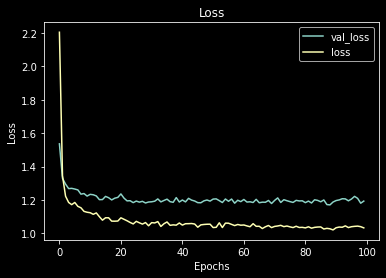

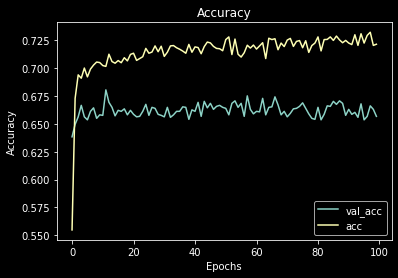

In [161]:
visualize_training_results(results_8)

Adding more data did not seem to improve anything at all. We have exhausted almost all of our options now with neural networks. Let's do one more thing: Trying out different optimization algorithms. We will take the best performing neural network as a test subject, which was the L1 regularized model with dropout

In [162]:
# RMSprop 
final_model_L1_dropout_2 = models.Sequential()
final_model_L1_dropout_2.add(layers.Dropout(0.2, input_shape = (2229, )))
final_model_L1_dropout_2.add(layers.Dense(25, activation = 'relu', kernel_regularizer=regularizers.l1(0.003)))
final_model_L1_dropout_2.add(layers.Dropout(0.2))
final_model_L1_dropout_2.add(layers.Dense(3, activation='softmax'))

final_model_L1_dropout_2.compile(optimizer = 'RMSprop', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [163]:
results_9 = final_model_L1_dropout_2.fit(x_train_scaled_1, y_train, 
                         epochs = 100, batch_size = 32, callbacks = early_stopping, validation_data = (x_val_scaled_1, y_val))

Epoch 1/100
210/210 [==============================] - 1s 5ms/step - loss: 1.4927 - accuracy: 0.6124 - val_loss: 1.0472 - val_accuracy: 0.6531
Epoch 2/100
210/210 [==============================] - 1s 4ms/step - loss: 1.0366 - accuracy: 0.6488 - val_loss: 0.9957 - val_accuracy: 0.6549
Epoch 3/100
210/210 [==============================] - 1s 4ms/step - loss: 1.0031 - accuracy: 0.6509 - val_loss: 0.9794 - val_accuracy: 0.6576
Epoch 4/100
210/210 [==============================] - 1s 4ms/step - loss: 0.9934 - accuracy: 0.6568 - val_loss: 0.9826 - val_accuracy: 0.6589
Epoch 5/100
210/210 [==============================] - 1s 4ms/step - loss: 0.9937 - accuracy: 0.6538 - val_loss: 0.9824 - val_accuracy: 0.6611
Epoch 6/100
210/210 [==============================] - 1s 4ms/step - loss: 0.9787 - accuracy: 0.6656 - val_loss: 0.9682 - val_accuracy: 0.6773
Epoch 7/100
210/210 [==============================] - 1s 4ms/step - loss: 0.9806 - accuracy: 0.6582 - val_loss: 0.9706 - val_accuracy: 0.6594

In [164]:
training_score = final_model_L1_dropout_2.evaluate(x_train_scaled_1, y_train)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = final_model_L1_dropout_2.evaluate(x_val_scaled_1, y_val)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.8538 - accuracy: 0.7071
Training Loss: 0.854 
Training Accuracy: 0.707
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 0.9226 - accuracy: 0.6728
Test Loss: 0.923 
Test Accuracy: 0.673


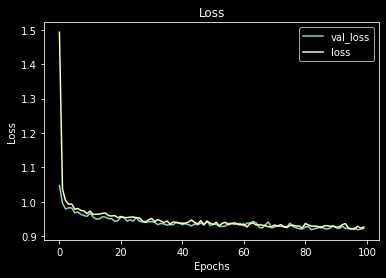

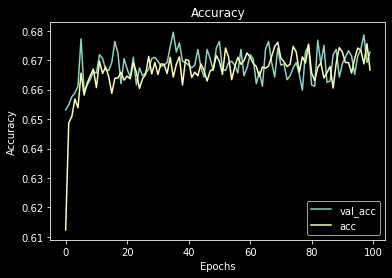

In [165]:
visualize_training_results(results_9)

In [180]:
# SGD 
final_model_L1_dropout_3 = models.Sequential()
final_model_L1_dropout_3.add(layers.Dropout(0.2, input_shape = (2229, )))
final_model_L1_dropout_3.add(layers.Dense(25, activation = 'relu', kernel_regularizer=regularizers.l1(0.003)))
final_model_L1_dropout_3.add(layers.Dropout(0.2))
final_model_L1_dropout_3.add(layers.Dense(3, activation='softmax'))

final_model_L1_dropout_3.compile(optimizer = 'SGD', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [181]:
final_model_L1_dropout_3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 2229)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 25)                55750     
_________________________________________________________________
dropout_9 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 78        
Total params: 55,828
Trainable params: 55,828
Non-trainable params: 0
_________________________________________________________________


In [182]:
results_10 = final_model_L1_dropout_3.fit(x_train_scaled_1, y_train, 
                         epochs = 100, batch_size = 32, callbacks = early_stopping, 
                         validation_data = (x_val_scaled_1, y_val))

Epoch 1/100
210/210 [==============================] - 1s 4ms/step - loss: 4.8693 - accuracy: 0.5521 - val_loss: 4.1645 - val_accuracy: 0.6280
Epoch 2/100
210/210 [==============================] - 1s 4ms/step - loss: 3.6647 - accuracy: 0.6620 - val_loss: 3.2756 - val_accuracy: 0.6513
Epoch 3/100
210/210 [==============================] - 1s 4ms/step - loss: 2.8279 - accuracy: 0.6959 - val_loss: 2.5584 - val_accuracy: 0.6656
Epoch 4/100
210/210 [==============================] - 1s 4ms/step - loss: 2.1615 - accuracy: 0.7153 - val_loss: 1.9962 - val_accuracy: 0.6598
Epoch 5/100
210/210 [==============================] - 1s 4ms/step - loss: 1.6714 - accuracy: 0.7264 - val_loss: 1.5815 - val_accuracy: 0.6629
Epoch 6/100
210/210 [==============================] - 1s 4ms/step - loss: 1.3408 - accuracy: 0.7244 - val_loss: 1.3162 - val_accuracy: 0.6661
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 1.1360 - accuracy: 0.7195 - val_loss: 1.1643 - val_accuracy: 0.6562

In [183]:
training_score = final_model_L1_dropout_3.evaluate(x_train_bigger_scaled, y_train_bigger)
print(f'Training Loss: {training_score[0]:.3} \nTraining Accuracy: {training_score[1]:.3}')

print('-' * 90)

testing_score = final_model_L1_dropout_3.evaluate(x_val_bigger_scaled, y_val_bigger)
print(f'Test Loss: {testing_score[0]:.3} \nTest Accuracy: {testing_score[1]:.3}')

210/210 [==============================] - 0s 1ms/step - loss: 0.9021 - accuracy: 0.7637
Training Loss: 0.902 
Training Accuracy: 0.764
------------------------------------------------------------------------------------------
70/70 [==============================] - 0s 1ms/step - loss: 0.9208 - accuracy: 0.7587
Test Loss: 0.921 
Test Accuracy: 0.759


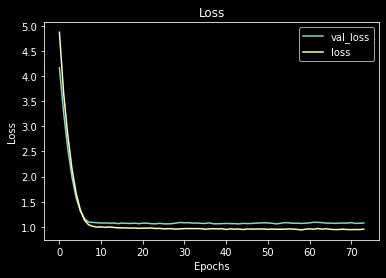

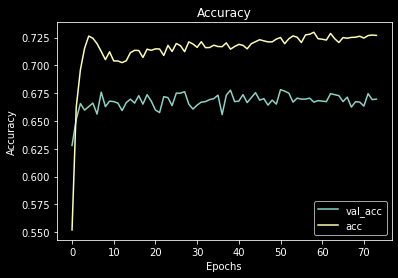

In [184]:
visualize_training_results(results_10)

This was the highest accuracy obtained, a very surprising increase in accuracy score! The model is neither too overfitted nor underfitted! This is by far our best performing model with the SGD optimizer algorithm!